# Environment Setup and Installation

This section installs the required dependencies for running the evaluation locally. It uses pip to install the necessary packages in an isolated environment.

Optional Protobuf Installation: A commented-out line to force reinstall a specific version of protobuf if needed.

In [ ]:
## If you want to use the evaluate locally, you need to install the requirements in an isolated environment
!pip install -I -r https://raw.githubusercontent.com/bigcode-project/bigcodebench/main/Requirements/requirements-eval.txt

# You are strongly recommended to install the bigcodebench dependencies in another environment
!pip install bigcodebench --upgrade

!pip install --upgrade huggingface_hub

# Optional: Reinstall a specific version of protobuf if needed (commented out)
# !pip install 'protobuf<=3.20.1' --force-reinstall

In [ ]:
import os
import re
import json
import subprocess
from datasets import load_dataset

# HuggingFace Authentication

User your hugginface auth token to get access to open source models used in this notebook.

In [ ]:
from huggingface_hub import login

# paste your token as a string (you can also read it from an env var)
login(token="ACCESS_TOKEN")

# Environment Variable Setup

Sets the *VLLM_ALLOW_LONG_MAX_MODEL_LEN* environment variable to 1, enabling the use of longer model lengths. Usfull for some model evaluation.

In [ ]:
# allow overriding the model‐max‐length
os.environ['VLLM_ALLOW_LONG_MAX_MODEL_LEN'] = '1'

# Model Names Definition

A list of model names is defined for evaluation. The model list have all the required model being evaluated while the research. All of the models are hosted on huggingface.

In [ ]:
model_names = [
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "bigcode/starcoder2-3b",
    "meta-llama/Llama-3.2-1B",
    "Qwen/Qwen2.5-Coder-1.5B-Instruct",
    "google/gemma-3-4b-it",
    "infly/OpenCoder-8B-Instruct",
    "microsoft/Phi-4-multimodal-instruct",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    "NousResearch/Hermes-2-Theta-Llama-3-8B",
    "meta-llama/CodeLlama-7b-Instruct-hf",
    "meta-llama/Llama-3.1-8B-Instruct",
    "Qwen/Qwen2.5-Coder-7B-Instruct",
    "bigcode/starcoder2-7b",
    "microsoft/phi-4--main",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    "deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct",
    "bigcode/starcoder2-15b-instruct-v0.1",
    # Additional models can be added here
]

# Model Generation Loop

- Defines paths to override default datasets and sets them as environment variables for evaluation.
    1. Override Paths: Specifies paths to dataset files.
    2. Environment Variable: Sets the BIGCODEBENCH_OVERRIDE_PATH environment variable for each dataset.

    You can use the already generated dataset under the dataset folder for the model evalaution.

- Runs the bigcodebench.generate command for each model and dataset.
    1. The command is already with the default arguments for the required results. 
    2. max_new_tokens is set to 3700 to support the code generation of all the prompts which exceed the default length of the prompt length being 1280. 
    2. Some models requires to trust the remote code for a successfull generation otherwise the failed to load.

- The default backend used is vllm.
- The output of the code generation of each model is generated under the examples folder with each folder named bcb_results_cmd{"cmd_value"}. 
- The generated code samples will be stored in a file named [model_name]--bigcodebench-complete--vllm-0-1-sanitized_calibrated.jsonl.

In [ ]:
# Define paths to override datasets and set them as environment variables
override_paths = [
    '../dataset/hindi-eng/MBigCodeBench-hini-end-cmd0.6.jsonl',
    '../dataset/hindi-eng/MBigCodeBench-hini-end-cmd0.9.jsonl',
]

# Key for the environment variable
key = "BIGCODEBENCH_OVERRIDE_PATH"

for path in override_paths:
    # Set the environment variable for the override path
    # This will override the dataset path for the generation command
    os.environ[key] = path
    print(f"\n▶️ Generating with BIGCODEBENCH_OVERRIDE_PATH={path}\n")

    # Loop through each model and run the generation command
    for model in model_names:
        command = [
            "bigcodebench.generate",
            "--model", model,
            "--split", "complete",
            "--subset", "full",
            "--max_new_tokens=3700",
            "--trust_remote_code=True"
        ]
        
        print(f"Running command for model: {model}")
        
        try:
            result = subprocess.run(command, check=True, env=os.environ)
            print(f"✅ Completed: {model}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed: {model} with error: {e}")

    
    # 3) after the inner loop, rename bcb_results → bcb_results_cmdX.Y
    m = re.search(r'cmd(\d+\.\d+)', path)
    suffix = m.group(1) if m else "unknown"
    src = "bcb_results"
    dst = f"bcb_results_cmd{suffix}"

    if os.path.isdir(src):
        # if a previous dst exists, you can choose to remove or skip
        if os.path.exists(dst):
            print(f"⚠️  Target folder {dst!r} already exists—skipping rename.")
        else:
            os.rename(src, dst)
            print(f"🔄 Renamed folder: {src!r} → {dst!r}")
    else:
        print(f"⚠️  Source folder {src!r} not found; nothing to rename.")
    

# Model Evaluation

- The following commands runs the bigcodebench.evaluate command for each generated result.
- All model generated files are listed under eval_model_names list.

- Output:
    1. All the resulted files will be stored in the same folder of model code example file.
    2. The evaluation results will be stored in a file named [model_name]--bigcodebench-complete--vllm-0-1-sanitized_calibrated_eval_results.json.
    3. The pass@k results will be stored in a file named [model_name]--bigcodebench-complete--vllm-0-1-sanitized_calibrated_pass_at_k.json.


In [ ]:
# the two result‐folders
dirs = ["bcb_results_cmd0.6", "bcb_results_cmd0.9"]

# List all model-generated files in the result folders
eval_model_names = [
    f"{d}/{fn}"
    for d in dirs
    for fn in os.listdir(d)
    if os.path.isfile(os.path.join(d, fn))
]

# Loop through each model and run the evaluation command
for model in eval_model_names:
    command = [
        "bigcodebench.evaluate",
        "--execution", "local",
        "--split", "complete",
        "--subset", "full",
        "--samples", model,
        "--save_pass_rate"
    ]
    
    print(f"Running evaluation for model: {model}")
    
    try:
        result = subprocess.run(command, check=True, env=os.environ)
        print(f"✅ Completed: {model}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed: {model} with error: {e}")
    

# Data Loading and Plotting

Loads evaluation results, calculates averages, and generates plots for comparison.

In [ ]:
# Import additional libraries for data loading and visualization
import os, glob, json
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

Plotting parameters for generating visual figures.

In [ ]:
# Create a folder for storing plots
Path("figs").mkdir(exist_ok=True)

plt.rcParams["pdf.fonttype"] = 42      # embed TrueType (NeurIPS requirement)
plt.rcParams["ps.fonttype"]  = 42

In [ ]:
# Define small, medium, and large model groups for visualization
small_models = {
    "deepseek": ["deepseek-ai--DeepSeek-R1-Distill-Qwen-1.5B--main"],
    "starcoder": ["bigcode--starcoder2-3b--main"],
    "meta": ["meta-llama--Llama-3.2-1B--main"],
    "qwen coder": ["Qwen--Qwen2.5-Coder-1.5B-Instruct--main"],
    "google": ["google--gemma-3-4b-it--main"]
}

medium_models = {
    "opencoder": ["infly--OpenCoder-8B-Instruct--main"],
    "microsoft": ["microsoft--Phi-4-multimodal-instruct--main"],
    "deepseek": ["deepseek-ai--DeepSeek-R1-Distill-Llama-8B--main"],
    "hermes": ["NousResearch--Hermes-2-Theta-Llama-3-8B--main"],
    "meta": ["meta-llama--CodeLlama-7b-Instruct-hf--main", "meta-llama--Llama-3.1-8B-Instruct--main"],
    "qwen coder": ["Qwen--Qwen2.5-Coder-7B-Instruct--main"],
    "starcoder": ["bigcode--starcoder2-7b--main"]
}

large_models = {
    "microsoft": ["microsoft--phi-4--main"],
    "deepseek": [
        "deepseek-ai--DeepSeek-R1-Distill-Qwen-14B--main",
        "deepseek-ai--DeepSeek-Coder-V2-Lite-Instruct--main"
    ],
    "starcoder": ["bigcode--starcoder2-15b-instruct-v0.1--main"]
}


In [ ]:
# Define the base paths for the results of CMD 0.6 and CMD 0.9
base_paths = {
    "0.6": "../eval/hindi-eng/bcb_results_cmd0.6",
    "0.9": "../eval/hindi-eng/bcb_results_cmd0.9"
}

# Initialize a dictionary to store data for each CMD version
data = {"0.6": [], "0.9": []}

# Loop through each CMD version and its corresponding result folder
for cmd, root in base_paths.items():
    for model_folder in os.listdir(root):   # List all model folders in the result folder
        results_dir = os.path.join(root, model_folder, "results")   # Path to the results directory
        pattern = os.path.join(results_dir, "*sanitized_calibrated_pass_at_k.json")
        for fn in glob.glob(pattern):   # Find all matching files
            with open(fn, 'r') as f:
                obj = json.load(f)
                data[cmd].append(obj)   # Append the data to the corresponding CMD version


# Helper: average pass@1 for a given model_id over a flat list of records
def avg_pass1(records, model_id):
    # Extract all pass@1 values for the given model ID from the records
    vals = [r["pass@1"] for r in records if r["model"] == model_id.strip()]
    
    if vals:
      return sum(vals) / len(vals)
    else:
      # print(f'Found none for :{model_id}')
      return None

# Visualization

- Generates plots comparing the performance of models across different datasets.
    1. Subplots: Creates a grid of plots for small, medium, and large models.
    2. Data Filtering: Filters models with valid data.
    3. Plotting: Plots average pass@1 scores for CMD 0.6, CMD 0.9, and baseline CSV data.

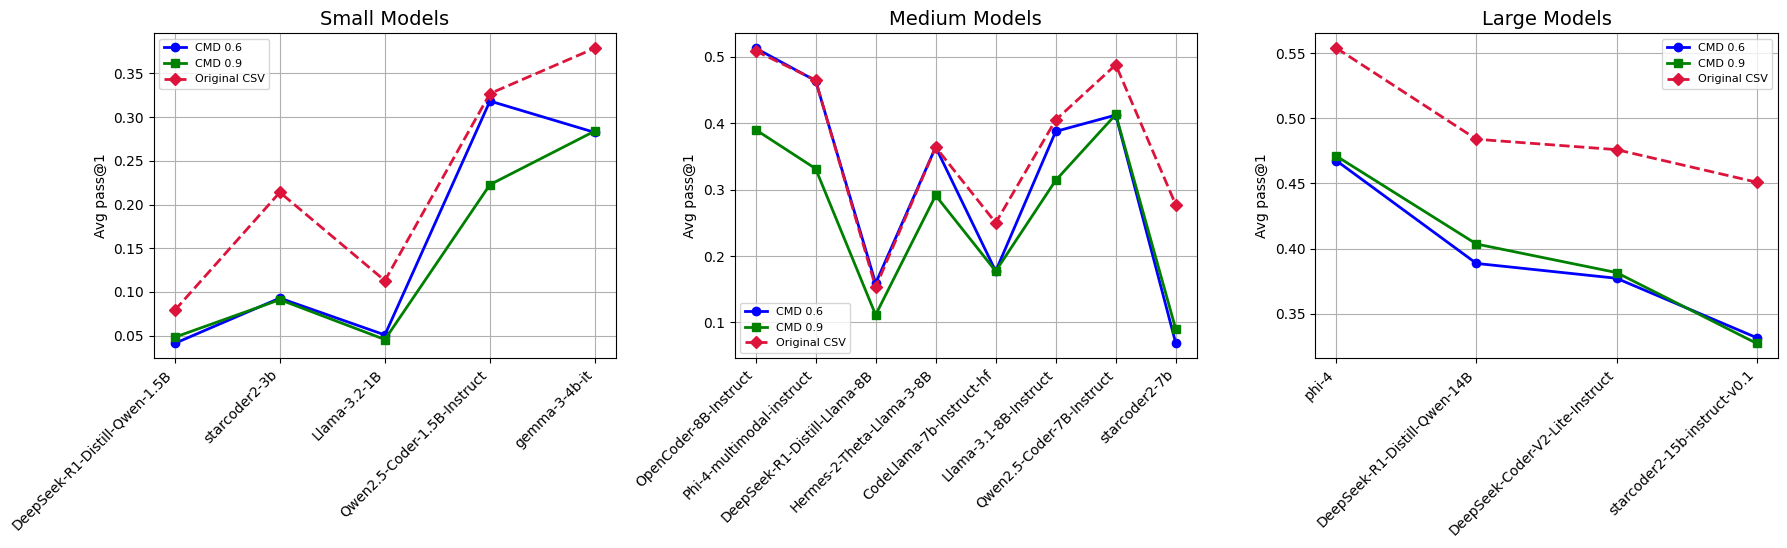

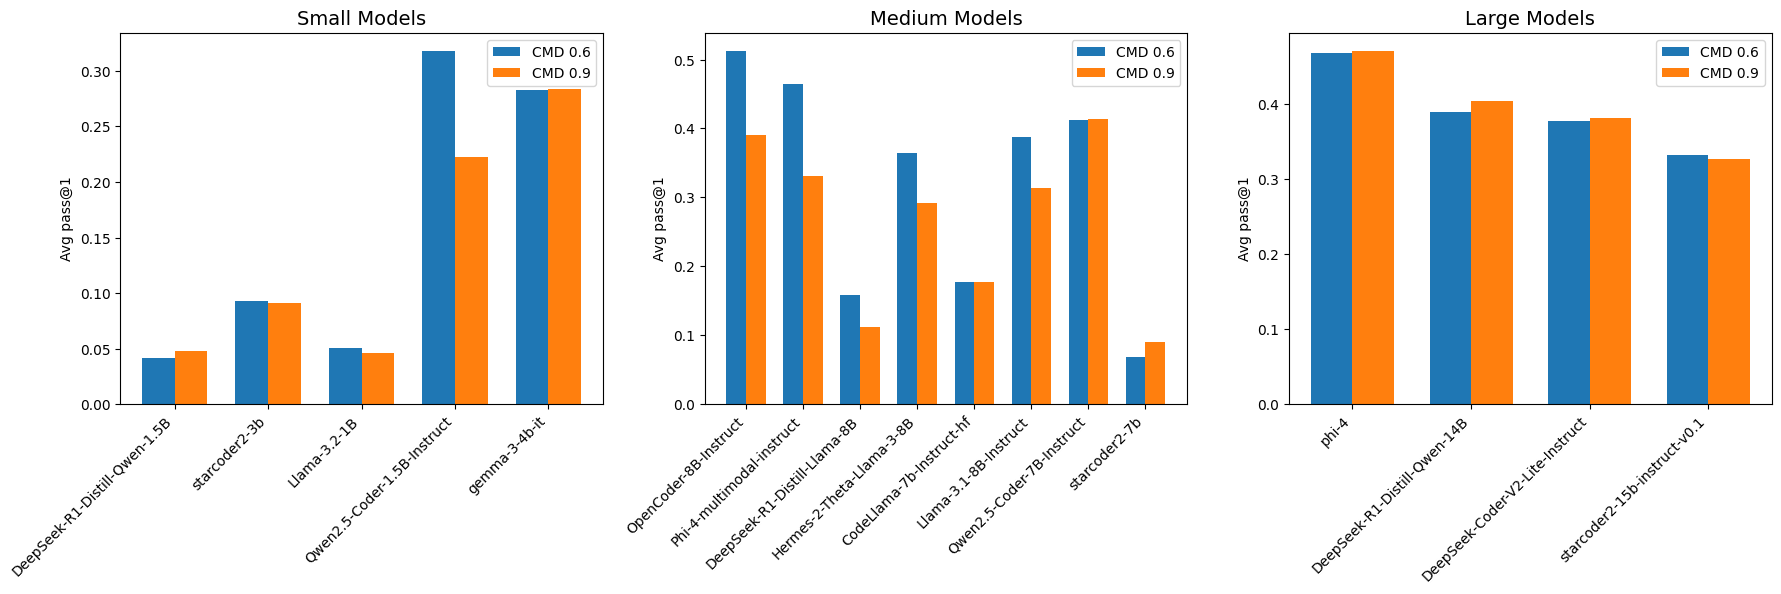

In [28]:
# Load the baseline results from a CSV file
df = pd.read_csv("../dataset/bigcodebench_results.csv")

# Normalize model names by converting them to lowercase for easier matching
df["model_lower"] = df["model"].str.lower()

# Function to extract `complete` score from CSV for a model_id
def get_csv_score(model_id):

    core_name = model_id.split("--", 1)[-1].replace("--main", "").lower()

    # Check if the model_id exists in the CSV file
    match = df[df["model_lower"].str.contains(core_name, na=False)]

    if not match.empty:
        return float(match.iloc[0]["complete"]) / 100.0
    else:
        print(f"id:{core_name} not found")
        return None


size_to_col = {"Small Models": 0, "Medium Models": 1, "Large Models": 2}

def shorten(name):
    return name.replace("deepseek-ai--", "") \
              .replace("bigcode--", "") \
              .replace("meta-llama--", "") \
              .replace("--main", "") \
              .replace("Qwen--","") \
              .replace("google--", "") \
              .replace("infly--", "") \
              .replace("microsoft--", "") \
              .replace("NousResearch--", "") \
              .replace("infly--","")

# 4) Create a 1x3 grid: Each model size gets one plot with 3 lines
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=False)
# fig.suptitle("CMD 0.6 vs CMD 0.9 vs BigCodeBench Baseline", fontsize=16)

size_to_col = {"Small Models": 0, "Medium Models": 1, "Large Models": 2}

for size_label, grouping in [
    ("Small Models",  small_models),
    ("Medium Models", medium_models),
    ("Large Models",  large_models)
]:
    ids = [mid for sub in grouping.values() for mid in sub]

    # Calculate average pass@1 scores for CMD 0.6, CMD 0.9, and baseline CSV data
    cmd06_vals = [avg_pass1(data["0.6"], mid) for mid in ids]
    cmd09_vals = [avg_pass1(data["0.9"], mid) for mid in ids]
    csv_vals   = [get_csv_score(mid) for mid in ids]

    # Filter out models with no valid data at all
    filtered = [(mid, a, b, c) for mid, a, b, c in zip(ids, cmd06_vals, cmd09_vals, csv_vals)
                if a is not None or b is not None or c is not None]

    if not filtered:
        continue

    # Unpack filtered data into separate lists
    model_names, p06, p09, p_csv = zip(*filtered)
    x_vals = list(range(len(model_names)))

    col_idx = size_to_col[size_label]
    ax = axes[col_idx]

    # Plot all three lines
    ax.plot(x_vals, p06, marker='o', linestyle='-', linewidth=2, label="CMD 0.6", color="blue")
    ax.plot(x_vals, p09, marker='s', linestyle='-', linewidth=2, label="CMD 0.9", color="green")
    ax.plot(x_vals, p_csv, marker='D', linestyle='--', linewidth=2, label="Original CSV", color="crimson")
    
    # Shorten model names for better readability
    short_names = [shorten(name) for name in model_names]
    
    ax.set_title(size_label, fontsize=14)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(short_names, rotation=45, ha="right", fontsize=10)
    ax.set_ylabel("Avg pass@1")
    ax.grid(True)
    ax.legend(fontsize=8)

# Adjust layout and save the plot as a PD
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("figs/cmd_results_grid.pdf")


# 5) Create a 1x3 grid with increased height for side-by-side comparison
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6.5), sharey=False)  # ⬅️ Increased height to 6.5
# fig.suptitle("CMD 0.6 vs CMD 0.9 — Side-by-Side per Model Size", fontsize=16)

for size_label, grouping in [
    ("Small Models",  small_models),
    ("Medium Models", medium_models),
    ("Large Models",  large_models)
]:
    all_ids = [mid for sub in grouping.values() for mid in sub]

    # Calculate average pass@1 scores for CMD 0.6 and CMD 0.9
    avg06 = [avg_pass1(data["0.6"], mid) for mid in all_ids]
    avg09 = [avg_pass1(data["0.9"], mid) for mid in all_ids]

    cats, p06, p09 = [], [], []
    for mid, a6, a9 in zip(all_ids, avg06, avg09):
        if a6 is not None or a9 is not None:
            cats.append(mid)
            p06.append(a6 or 0)
            p09.append(a9 or 0)

    cats = [shorten(name) for name in cats]

    x = range(len(cats))
    w = 0.35
    col_idx = size_to_col[size_label]
    ax = axes[col_idx]

    # Plot CMD 0.6 and CMD 0.9 as side-by-side bars
    ax.bar([i - w/2 for i in x], p06, width=w, label="CMD 0.6")
    ax.bar([i + w/2 for i in x], p09, width=w, label="CMD 0.9")

    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=45, ha="right", fontsize=10)
    ax.set_ylabel("Avg pass@1")
    ax.set_title(size_label, fontsize=14)
    ax.legend()

# Adjust layout and save the plot as a PDF
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("figs/cmd_combined_results.pdf")
plt.show()